In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import great_circle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

### Step 1: Loading the data

In [2]:
df =pd.read_csv('\\Users\\cofos\\Downloads\\lisitngs.csv')

#define the columns we want to keep
columns_to_included = ['last_scraped','host_since', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'square_feet', 'price', 'cleaning_fee','number_of_reviews',
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'cancellation_policy','require_guest_profile_picture',]

# Select the columns we need for the analysis

df= df[columns_to_included]
df.head()

,last_scraped,host_since,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,price,cleaning_fee,number_of_reviews,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,cancellation_policy,require_guest_profile_picture
0,1/4/2016,8/11/2011,t,Queen Anne,47.636289,-122.371025,Apartment,Entire home/apt,4,1.0,...,$85.00,NaN,207,NaN,$5.00,2,1,f,moderate,f
1,1/4/2016,2/21/2013,t,Queen Anne,47.639123,-122.365667,Apartment,Entire home/apt,4,1.0,...,$150.00,$40.00,43,$100.00,$0.00,1,2,f,strict,t
2,1/4/2016,6/12/2014,t,Queen Anne,47.629724,-122.369483,House,Entire home/apt,11,4.5,...,$975.00,$300.00,20,"$1,000.00",$25.00,10,4,f,strict,f
3,1/4/2016,11/6/2013,t,Queen Anne,47.638473,-122.369279,Apartment,Entire home/apt,3,1.0,...,$100.00,NaN,0,NaN,$0.00,1,1,f,flexible,f
4,1/4/2016,11/29/2011,t,Queen Anne,47.632918,-122.372471,House,Entire home/apt,6,2.0,...,$450.00,$125.00,38,$700.00,$15.00,6,1,f,strict,f


In [3]:
missing_values = df.isnull().sum(axis=0).reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values.loc[missing_values['missing_count']>0]
missing_values = missing_values.sort_values(by='missing_count')
missing_values

,column_name,missing_count
6,property_type,1
1,host_since,2
2,host_has_profile_pic,2
10,bedrooms,6
9,bathrooms,16
14,cleaning_fee,1030
16,security_deposit,1952
12,square_feet,3721


### Step 2: Data cleaning

In [4]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    df - pandas dataframe
    This function cleans df using the following steps:
    1. The price column has certain characters such as $ and comma that need to be remove and convert them to float.
    2. Filling missing values with mode for the categorical variables and 0.00 for price columns.
    3. Change columns with dtype object to category.
    '''
#The price column has certain characters such as $ and comma that need to be remove and convert them to float
    df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)
    df['cleaning_fee'] = df['cleaning_fee'].str.replace('$', '').str.replace(',', '').astype(float)
    df['extra_people'] = df['extra_people'].str.replace('$', '').str.replace(',', '').astype(float)
    df['security_deposit'] = df['security_deposit'].str.replace('$', '').str.replace(',', '').astype(float)

    #Filling missing values with median for numerical varaibles 
    
    df.loc[df.bedrooms.isnull(), "bedrooms"] = df.groupby('room_type').bedrooms.transform('median')
    df.loc[df.bathrooms.isnull(), "bathrooms"] = df.groupby('room_type').bathrooms.transform('median')
    df['cleaning_fee'].fillna(0.00,inplace=True)
    df['security_deposit'].fillna(0.00,inplace=True)

#fill missing values with mode for categorical variables
 
    df['host_has_profile_pic'] = df['host_has_profile_pic'].fillna(df['host_has_profile_pic'].mode()[0]) 
    df['property_type'] = df['property_type'].fillna(df['property_type'].mode()[0])
    df['require_guest_profile_picture'] = df['require_guest_profile_picture'].fillna(df['require_guest_profile_picture'].mode()[0])
    
    #fill in nan's for host since column with back fill and forward fill
    
    df['host_since']= df['host_since'].fillna(method ='ffill').fillna(method ='bfill')
    
# change the datatype of host since to datatime
    df['last_scraped'] = pd.to_datetime(df['last_scraped'])
    df['host_since'] = pd.to_datetime(df['host_since'])
    
    df = df.drop(columns=['square_feet'])

                                                                       
                                                                       
    return df
df = clean_data(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   last_scraped                   3818 non-null   datetime64[ns]
 1   host_since                     3818 non-null   datetime64[ns]
 2   host_has_profile_pic           3818 non-null   object        
 3   neighbourhood_group_cleansed   3818 non-null   object        
 4   latitude                       3818 non-null   float64       
 5   longitude                      3818 non-null   float64       
 6   property_type                  3818 non-null   object        
 7   room_type                      3818 non-null   object        
 8   accommodates                   3818 non-null   int64         
 9   bathrooms                      3818 non-null   float64       
 10  bedrooms                       3818 non-null   float64       
 11  bed_type         

### Step 2 Feature Engineering
* Location and number of years listed might have some influence on pricing.

* Distance from the city center to the accommodation was calculated instead of using neighbourhood.

* I calculated number of years listed by subtracting host_since from last_scraped.

* Also property type has many categoriies. Therefore recategorization into four types, Apartment building, hotels, family house and cabin, yort, boat were all categorized as other

In [6]:
def distance_to_loc(lat, long):
    ''' this function take the latitude and longitude of a location and calculate
        the distance from the location to the center of the city in kilometers
    '''
    center_berlin = (52.520008,13.404954)
    accommodation = (lat, long)
    return great_circle(center_berlin, accommodation).km
df['distance'] = df.apply(lambda x: distance_to_loc(x.latitude, x.longitude), axis=1)

In [7]:
df['no_years_listed'] = round((df['last_scraped'] - df['host_since']).dt.days/365,1)

In [8]:
#Recategorizing property type column.
def get_property_type(col):
    if col == 'Apartment' :
        return 'Apartment_building'
    elif col == 'Condominium':
        return 'Apartment_building'
    elif col == 'Loft':
        return 'Apartment_building'
    elif col == 'Serviced apartment':
        return 'Apartment_building'
    
    elif col == 'House':
        return 'Family_house'
    elif col == 'Townhouse':
        return 'Family_house'
    elif col == 'Bungalow':
        return 'Family_house'
    
    elif col == 'Hotel':
        return 'Hotel'
    elif col == 'Bed & Breakfast':
        return 'Hotel'
    elif col == 'Hostel':
        return 'Hotel'
    elif col == 'Boutique hotel':
        return 'Hotel'
    elif col == 'Guest suite':
        return 'Hotel'
    elif col == 'Guesthouse':
        return 'Hotel'
    elif col == 'Aparthotel':
        return 'Hotel'
    
    else:
        return 'others'
df['property_type'] = df['property_type'].apply(get_property_type)

In [9]:
def get_neighbourhood(col):
    if col == 'Capitol Hill' :
        return 'Capitol Hill'
    elif col == 'Downtown':
        return 'Downtown'
    elif col == 'Central Area':
        return 'Central Area'
    elif col == 'Queen Anne':
        return 'Queen Anne'
    
    elif col == 'Ballard ':
        return 'Ballard '
    elif col == 'West Seattle':
        return 'West Seattle'
    else:
        return 'others neighbourhood'
df['neighbourhood_group_cleansed'] = df['neighbourhood_group_cleansed'].apply(get_neighbourhood)

In [10]:
df.columns

Index(['last_scraped', 'host_since', 'host_has_profile_pic',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'bed_type', 'price', 'cleaning_fee', 'number_of_reviews',
       'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'distance', 'no_years_listed'],
      dtype='object')

In [11]:
df = df.drop(columns = ['last_scraped','host_since','bed_type','latitude','longitude'],axis =1)

### Step 3 Feature Selection

In [12]:
def extract_feature(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    df - pandas dataframe
    This function using the following steps to produce X and y:
    1. separate numerical and categorical dtypes
    2. Create dummy columns for all the categorical variables
    3. Drop the price column from X as independent variables
    4. create Y or dependent variable
    '''
    
    # Separate numeric and Categorical variable
    df_numeric = df.select_dtypes(include=['float64', 'int64', ]).copy()
    df_cat = df.select_dtypes(include=['category','object']).copy()
    
    # create dummy variables for categorical variables
    df_cat = pd.get_dummies(df_cat,drop_first=True)
    df_final = pd.concat([df_numeric,df_cat], axis=1)
    
     # define our features
    x = df_final.drop(['price'],axis = 1)
    
    #define target
    y = np.log1p(df_final['price'])
    return  x,y


In [13]:
x,y = extract_feature(df)
 #Splitting data 
    
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

### Step 4 Model Selection

In [14]:
#define model
model = LinearRegression()
#bundle scaling and modelling code in pipeline
my_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                             ('model',model)])
#preprocessinf of training data, fit model
my_pipeline.fit(X_train, y_train)
#preprocessing of validation data, get predictions
y_preds = my_pipeline.predict(X_test)

print('R-square:', r2_score(y_test, y_preds))
    
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_preds))  
    
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_preds))  
    
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_preds)))
    

R-square: 0.6661118020673658
Mean Absolute Error: 0.24964477847853483
Mean Squared Error: 0.10348650509351387
Root Mean Squared Error: 0.32169318471723


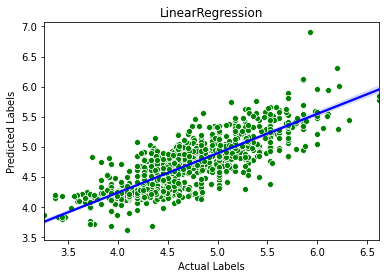

In [15]:
lin_data = pd.DataFrame({'Predicted Labels':y_preds, 'Actual Labels':y_test})

ax = sns.scatterplot(data=lin_data, x="Actual Labels", y="Predicted Labels", color='green')
#add a regression line
sns.regplot(data=lin_data, x="Actual Labels", y="Predicted Labels", scatter=False, ax=ax, color='blue')
plt.title('LinearRegression')
plt.show()

In [16]:
pipeline1 = Pipeline([('scaling', StandardScaler()),
                      ('decision',DecisionTreeRegressor(max_depth=5,random_state=1))])
    
    # train model
pipeline1.fit(X_train, y_train)
    
    # predict on test data
y_pred1 = pipeline1.predict(X_test)
    
    # display results
print('R-square:', r2_score(y_test, y_pred1))
    
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred1))  
    
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred1))  
    
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred1)))
    
    
    
     

R-square: 0.6330640691008116
Mean Absolute Error: 0.2658115551441573
Mean Squared Error: 0.11372943792896086
Root Mean Squared Error: 0.3372379544608834


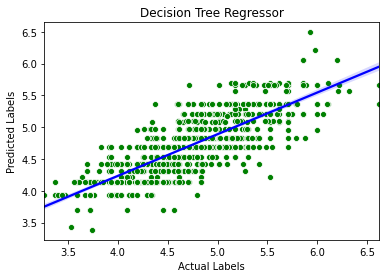

In [17]:
data = pd.DataFrame({'Predicted Labels':y_pred1, 'Actual Labels':y_test})

ax = sns.scatterplot(data=data, x="Actual Labels", y="Predicted Labels", color='green')
#add a regression line
sns.regplot(data=lin_data, x="Actual Labels", y="Predicted Labels", scatter=False, ax=ax, color='blue')
plt.title('Decision Tree Regressor')
plt.show()

In [18]:

pipeline2 = Pipeline([('scaling', StandardScaler()),
                      ('gbr',GradientBoostingRegressor())])
    
    # train model
pipeline2.fit(X_train, y_train)
    
    # predict on test data
y_pred2 = pipeline2.predict(X_test)
    
    # display results

print('R-square:', r2_score(y_test, y_pred2))
    
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred2))  
    
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred2))  
    
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))
    

     

R-square: 0.7135714926940953
Mean Absolute Error: 0.23501653801082695
Mean Squared Error: 0.08877667843240329
Root Mean Squared Error: 0.29795415491716726


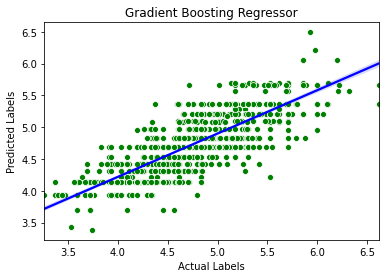

In [19]:
data2 = pd.DataFrame({'Predicted Labels':y_pred2, 'Actual Labels':y_test})

ax = sns.scatterplot(data=data, x="Actual Labels", y="Predicted Labels", color='green')
#add a regression line
sns.regplot(data=data2, x="Actual Labels", y="Predicted Labels", scatter=False, ax=ax, color='blue')
plt.title('Gradient Boosting Regressor')
plt.show()

In [20]:
# Build pipeline
pipeline3 = Pipeline([('scaling', StandardScaler()),
                      ('rf',RandomForestRegressor())])
    
    # train model
pipeline3.fit(X_train, y_train)
    
    # predict on test data
y_pred3 = pipeline3.predict(X_test)
    
    # display results
    
print('R-square:', r2_score(y_test, y_pred3))
    
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred3))  
    
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred3))  
    
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred3)))
    



R-square: 0.6978613803413096
Mean Absolute Error: 0.23277811494492998
Mean Squared Error: 0.09364592697752327
Root Mean Squared Error: 0.30601622012161916


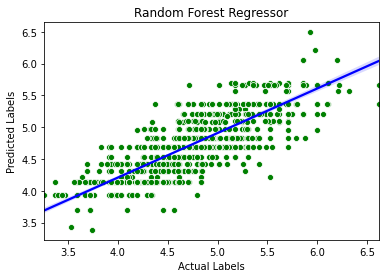

In [21]:
data2 = pd.DataFrame({'Predicted Labels':y_pred3, 'Actual Labels':y_test})

ax = sns.scatterplot(data=data, x="Actual Labels", y="Predicted Labels", color='green')
#add a regression line
sns.regplot(data=data2, x="Actual Labels", y="Predicted Labels", scatter=False, ax=ax, color='blue')
plt.title('Random Forest Regressor')
plt.show()
     

### Step 5 Fine-tune Random Forest and GradientBoost

In [22]:
# Fine-tune Random Forest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start =10,stop=80,num = 10)]

# number of features to consider at every split
max_features = ['auto','sqrt']

# Maximum number of level in tree
max_depth = [2,4]

# Minimum number of sample required to split a node
min_samples_split = [2,5]

#Minimum number of sample required at each node
min_samples_leaf = [1,2]

# Method of selecting samples for training eac tree
bootstrap = [True,False]

In [23]:
param_grid = {'n_estimators': n_estimators,
             'max_features': max_features,
             'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'bootstrap': bootstrap
            }


#### hypertuning the best model which is the random forest regressor using gridsearchcv



In [24]:
rf1 =RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf1, param_grid = param_grid,
                          cv = 3, n_jobs = 4, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   21.4s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   34.3s
[Parallel(n_jobs=4)]: Done 960 out of 960 | elapsed:   51.0s finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 4],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=2)

In [25]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_search.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=4, min_samples_split=5, n_estimators=56)

 The best score across ALL searched params:
 0.6341521820291989

 The best parameters across ALL searched params:
 {'bootstrap': True, 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 56}


In [26]:
#print(f'Train Accuracy: {grid_search.score(X_train,y_train):.3f}')

print('Train Accuracy: %.3f' % grid_search.score(X_train, y_train))

print('Test Accuracy: %.3f' % grid_search.score(X_test, y_test))

Train Accuracy: 0.659
Test Accuracy: 0.652
